# Project

In [2]:
import pandas as pd
import json as JSON
import numpy as np

from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from pyspark.ml.fpm import PrefixSpan
from pyspark.shell import sc
from pyspark.sql.functions import desc
from pyspark.sql.types import Row

import matplotlib.pyplot as plt

import ast

### Our dataset

#### Description

The platform the users used for writing recipes is a ML based review on recipes users write. First they type their recipes and the model gives feedback in the form of suggestions, more complete sentences etc, and the user can either review their recipe or pick the one generated by the model directly. The model compares user input with thousands of recipes and bases its suggestions off of that.

We have 187 users (each represented by a ```user_id```) writing one or multiple recipes each. Our data consists of 1091 sets of keystrokes which I thought initially were 1091 different recipes but actually each set of keystrokes is a users revision on what they wrote previously. What I imagine a scenario is when using the platform is 
- User x writes a first version of a recipe, clicks finished button (registers as a set of keystrokes in our dataset)
- The platform analyses the recipe and offers suggestions on what the user can add or write instead
- The user modifies their text according to the suggestions and clicks on finish button (registers as a second set of keystrokes in our dataset)
- Again the platform has suggestions and the user can modify once more and so on...


Here is our planning I will follow
First 
* Copy the original dataset 
* Clean and sort the data set, group the characters typed as words and sort by user_id and event_date such that we have in order what each user wrote from when they started writing to when they finished
* Count the most common words
* Apply some basic pattern mining on the recipes the users write
* 

In [3]:
df = pd.read_csv('keystrokes-recipes.csv')
KEYWORDS = ['Shift', 'Backspace', 'Enter', 'ArrowDown',
            'ArrowLeft', 'ArrowRight', 'ArrowUp', 'End', 'Control', 'CapsLock']
noisy_punct = [',', '.', '-', ':', '(', ')']
#create a copy of the dataset to another csv file

df.to_csv('keystrokes-recipes-modified.csv', index=False)

- ```keystrokes-recipes.csv``` is the original data and we keep it in case we want to look back at one moment
- ```keystrokes-recipes-modified.csv``` is the modified data


## Data cleaning and sorting


Our data consists of a csv file with event dates, user ids, keystrokes and the recipes they wrote.
We clean all the data by working throught the keystrokes first.

* We group the characters into the word written and separate between important keywords typed such as backspace, shift, enter etc. The sequence ['shift', 'p', 'e', 'r'] becomes ['shift', 'per'] 
* We sort by user id to get a better idea of every recipe every student has written.

### Sorting by user id and event date

We first sort by user id in order to differentiate behaviour between different people more easily

In [4]:
csv_filename = 'keystrokes-recipes-modified.csv'
#we sort 
pd.read_csv(csv_filename).sort_values(by=['user_id', 'event_date'], ascending=True).to_csv('sortedbytime.csv', index=False)
csv_filename = 'sortedbytime.csv'

### Processing the data


The first thing we did was isolate the keystrokes to a new ```json``` file saved in ```data/all_keystrokes.json```

The next step is to group words together and separate them from keywords and we work between each whitespace.
 
So for example this entry: 

```{'time': 1662252404346, 'character': 'Shift'}, {'time': 1662252404376, 'character': 'f'}, {'time': 1662252404505, 'character': 'i'}``` 

gives the following output: 

```{'time': 1662252404346, 'word': 'Shift'}, {'time': 1662252404505, 'word': 'fi'}```


In [5]:
def find_seq(chars):
    return "".join(list(filter(lambda _ : _ not in KEYWORDS, chars)))

def separate_entry(json_values):
    new_data = []
    last_whitespace = 0
    characters = [arr[1] for arr in json_values]

    for i, (time, character) in enumerate(json_values):
        if character.isspace():
            word = characters[last_whitespace: i]
            if not any(i in word for i in KEYWORDS):
                new_data.append({'time': time, 'word': "".join(word)})
            else:
                new_data.append({'time': time, 'word': find_seq(word)})
            last_whitespace = i+1

        elif character in KEYWORDS:
            new_data.append({'time': time, 'word': character})
        
        elif not character:
            continue

    return new_data

def compute():
    new_df = pd.DataFrame(pd.read_json("data/all_keystrokes.json"))
    arr = []
    for jsonf in new_df.values:
        sub_arr = []
        for d in jsonf:
            if d is not None:
                sub_arr.append([d["time"], d["character"]])
        arr.append(sub_arr)

    result = []
    for jsonf in arr:
        result.append(separate_entry(jsonf))

    with open("data/new_data.json", "w") as f:
        JSON.dump(result, f)
    return

compute()



Basically, ``` compute()``` will format the data for the ```separate_entry``` function and when everything is computed, it dumps all the data in a new json file.

```separate_entry``` computes the words between each space character, all the while separating words from keywords. It uses the function ```find_seq``` to separate the characters from keywords so it allows to isolate words between each whitespaces.


### Modifying the CSV file

We just modify the keystroke data for each row of the original data in ```keystrokes-recipes.csv``` but apply it to ```keystrokes-recipes-modified.csv```

In [6]:
jsons = pd.read_json('data/new_data.json').values.tolist()

for i, json in enumerate(jsons):
    jsons[i]= list(filter(lambda _ : _ is not None, json))

def write_to_csv_file(filename, recipes_len):
    df = pd.read_csv(filename)
    for i in range(recipes_len):
        df.loc[i,'ks'] = jsons[i]
    df.to_csv(filename, index=False)

write_to_csv_file(csv_filename, len(jsons))

df = pd.read_csv(csv_filename)


### Cheaters?

We want to remove noisy samples from our dataset, that is, samples that could lead to misinterpretations in the results we will analyse.

As such, we can consider cheaters as users who cheat the system and input a very small amount of words and then use the generated recipe as theirs. We consider them as cheaters because what we want to study is how the users write and how they revise and having users input a single word is useless. We set the requirement as chars_typed $= \frac{1}{3}$ recipe_length

We can also consider cheaters as people who have subsequences ```CTRL + C, CTRL+V``` in the characters typed as copy and pasting a recipe is not worth looking at and analysing what was written.

So what we do first is find the indices of the recipes which have the sequences we discussed.

In [7]:
"""
def is_sublist(l,s):
    sub_set = False
    if s == []:
        sub_set = True
    elif s == l:
        sub_set = True
    elif len(s) > len(l):
        sub_set = False

    else: 
        for i in range(len(l)):
            if l[i] == s[0]:
                n = 1
                if i + n < len(l):
                    while (n < len(s)) and (l[i+n] == s[n]):
                        n+=1
                    if n == len(s):
                        sub_set = True

    return sub_set


keystrokes = pd.read_json('data/all_keystrokes.json').values
ks_per_recipe = []
for recipe in keystrokes:
    ks = []
    for char in (d['character'] if d is not None else -1 for d in recipe): 
        if char != -1: 
            ks.append(char)
    ks_per_recipe.append(ks)

#basically what we do is count the number of insertions and deletions for each recipe
#we will then remove those who don't have the minimum requirements to stay in the dataset
inserts = [len(list(filter(lambda _ : _ not in KEYWORDS, recipe))) for recipe in ks_per_recipe]
deletions = [len(list(filter(lambda _ : _ == 'Backspace', recipe))) for recipe in ks_per_recipe]
recipe_insertions_deletions = list(zip(inserts, deletions))


#we set the requirement as being the number of inserts is less than 1/3 of the length of the recipe

recipe_lengths = list(map(lambda recipe : len(recipe), df['recipe'].values))

#enumerate(recipe_insertions_deletions) will have the form (index, (inserts, deletes)) so in the 
# filter we put t[1][0] < 1/3*recipe_length[t[0]] ===== inserts at index t[0] < 1/3 length of recipe at index t[0]
noisy_samples = list((filter(lambda t: t[1][0] < 1/4 * recipe_lengths[t[0]], enumerate(recipe_insertions_deletions))))

indices = list(map(lambda _: _[0], noisy_samples))
print(indices)

print(df.iloc[9]['ks'])
print(df.iloc[9]['recipe'])
cheater_subsequence1, cheater_subsequence2 = ['Control', 'c'], ['Control', 'v']
cheater_indices = []
for i, ks in enumerate(ks_per_recipe):
    if is_sublist(ks, cheater_subsequence1) or is_sublist(ks, cheater_subsequence2):
        cheater_indices.append(i)
        """

"\ndef is_sublist(l,s):\n    sub_set = False\n    if s == []:\n        sub_set = True\n    elif s == l:\n        sub_set = True\n    elif len(s) > len(l):\n        sub_set = False\n\n    else: \n        for i in range(len(l)):\n            if l[i] == s[0]:\n                n = 1\n                if i + n < len(l):\n                    while (n < len(s)) and (l[i+n] == s[n]):\n                        n+=1\n                    if n == len(s):\n                        sub_set = True\n\n    return sub_set\n\n\nkeystrokes = pd.read_json('data/all_keystrokes.json').values\nks_per_recipe = []\nfor recipe in keystrokes:\n    ks = []\n    for char in (d['character'] if d is not None else -1 for d in recipe): \n        if char != -1: \n            ks.append(char)\n    ks_per_recipe.append(ks)\n\n#basically what we do is count the number of insertions and deletions for each recipe\n#we will then remove those who don't have the minimum requirements to stay in the dataset\ninserts = [len(list(filte

So now what we do is classify the certain cheaters with the criteria we selected

In [8]:
"""
recipe_df = pd.DataFrame(recipe_insertions_deletions, columns=['insertions', 'deletions'])

average_insertions_per_recipe = recipe_df['insertions'].mean()
average_deletions_per_recipe = recipe_df['deletions'].mean()

certain_cheaters = []
num_times_user_copy_pasted = dict.fromkeys(df['user_id'], 0)

certain_cheater_plot = []
others_plot = []

for index in cheater_indices:
    row_in_data = df.iloc[index]
    num_times_user_copy_pasted[row_in_data['user_id']] += 1
    num_insertions = recipe_df.iloc[index]['insertions']
    
    recipe_len = len(row_in_data['recipe'])
    if num_insertions < 1000:
        print(index, num_insertions,recipe_len)

    if num_insertions < recipe_len or num_insertions < .4 * average_insertions_per_recipe:
        certain_cheaters.append(index)
        certain_cheater_plot.append((num_insertions, recipe_len))
    else:
        others_plot.append((num_insertions, recipe_len))
        """
 

"\nrecipe_df = pd.DataFrame(recipe_insertions_deletions, columns=['insertions', 'deletions'])\n\naverage_insertions_per_recipe = recipe_df['insertions'].mean()\naverage_deletions_per_recipe = recipe_df['deletions'].mean()\n\ncertain_cheaters = []\nnum_times_user_copy_pasted = dict.fromkeys(df['user_id'], 0)\n\ncertain_cheater_plot = []\nothers_plot = []\n\nfor index in cheater_indices:\n    row_in_data = df.iloc[index]\n    num_times_user_copy_pasted[row_in_data['user_id']] += 1\n    num_insertions = recipe_df.iloc[index]['insertions']\n    \n    recipe_len = len(row_in_data['recipe'])\n    if num_insertions < 1000:\n        print(index, num_insertions,recipe_len)\n\n    if num_insertions < recipe_len or num_insertions < .4 * average_insertions_per_recipe:\n        certain_cheaters.append(index)\n        certain_cheater_plot.append((num_insertions, recipe_len))\n    else:\n        others_plot.append((num_insertions, recipe_len))\n        "

To kind of visualise everything we can plot the values of the ```cheated_indices``` total insertions with the length of the recipe they wrote.
And we set the ones we think are certain cheaters in red and the potential cheaters in blue.

In [9]:
"""certain_cheaters_df = pd.DataFrame(certain_cheater_plot, columns=['insertions', 'recipe length'])
other_cheaters_df = pd.DataFrame(others_plot, columns=['insertions', 'recipe length'])

ax1 = certain_cheaters_df.plot(kind='scatter', x='recipe length', y='insertions', color='r', label='certain cheaters')    
ax2 = other_cheaters_df.plot(kind='scatter', x='recipe length', y='insertions', color='b', ax=ax1, label='potential cheaters')    
"""

"certain_cheaters_df = pd.DataFrame(certain_cheater_plot, columns=['insertions', 'recipe length'])\nother_cheaters_df = pd.DataFrame(others_plot, columns=['insertions', 'recipe length'])\n\nax1 = certain_cheaters_df.plot(kind='scatter', x='recipe length', y='insertions', color='r', label='certain cheaters')    \nax2 = other_cheaters_df.plot(kind='scatter', x='recipe length', y='insertions', color='b', ax=ax1, label='potential cheaters')    \n"

## Identifying patterns between different student recipes

Count the most common words used in the recipes and removing stopwords (they're noisy)

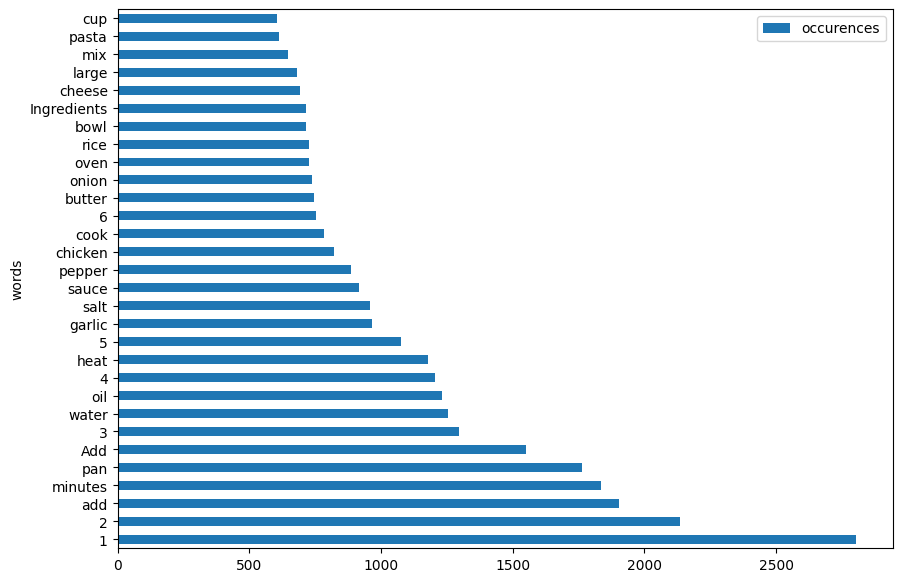

In [10]:
def flatten_and_filter_strings(ls):
    flat_list = [elem if elem not in noisy_punct and elem not in stop_words else -1 for sublist in ls for elem in sublist]
    flat_list = list(filter(lambda _ : _ != -1, flat_list))
    return flat_list

data = df['recipe'].values
stop_words = set(stopwords.words('english'))
def count_and_plot_most_common_words(data):
    """
    count the occurence of each word in data
    data: list[str]
    """
    c = Counter(data)
    dframe = pd.DataFrame(c.most_common(30), columns=['words', 'occurences'])
    dframe.plot(kind='barh', x='words', y='occurences', figsize=(10,7))


recipes_copy = list(map(lambda _ : word_tokenize(_), data.copy()))
count_and_plot_most_common_words(flatten_and_filter_strings(recipes_copy))

Most of the recipes contain an order in which to proceed - ie 1) --- 2) --- 
Also interesting to see most of the common words are not ingredients

### Pattern mining

There are a total of 187 students. What we would like to do is either apply pattern mining for each student and their recipes to better understand each users writing. Or, we pick one recipe from each student and extract the underlying patterns each student share.

Given our data, we want to extract the longest common patterns as the shorter ones will only consist of heavily used words such as 'the', 'and'. To start, we will apply PrefixSpan on the first content that each user writes. That means when each user has never used the suggestion tool yet!!
Then we will pick the final recipe they submitted and apply PS again and see whether there were any changes

A word about ```PrefixSpan```

Parameters: 
* Minimum Support (```minSupport```) : support is calculated as the % of sequences containing the subsequence
* Maximum Subsequence Length (```maxPatternLength```) : speaks for itself

If ```minSupport``` is little and ```maxPatternLength``` is large, the running time of ```PrefixSpan``` gets exceedingly long. The contrary gives reasonable running time but some subsequences can be left undiscovered.


In [73]:
def apply_prefixSpan(data, minSupport=0.2, maxPatternLength=8, kind='barh', title=""):
    """
    input an array of indices on which you want to apply prefix span. So for example, we want to apply it to the first 
    thing users write so we input the indices of the first text they write in ...
    indices = list[int] -> the indices of the data we want to look at
    data = list[list[obj]] -> list of sentences ie list of lists of words
    """
    range_ = range(len(data))
    #map to rows so that
    for i in range_:
        data[i] = Row(sequence=[data[i]])

    l = [data[i] for i in range_]

    DF = sc.parallelize(l).toDF()

    prefixSpan = PrefixSpan(minSupport=minSupport, maxPatternLength=maxPatternLength, maxLocalProjDBSize=32000000)

    # Find frequent sequential patterns.
    find_pat = prefixSpan.findFrequentSequentialPatterns(DF).sort(desc('freq')).collect()

    NUM_PATTERNS_TO_PLOT = 25

    df2 = pd.DataFrame(list(map(lambda _: _.asDict(), find_pat[:NUM_PATTERNS_TO_PLOT])))
    df2.plot(kind=kind,x='sequence', y='freq', figsize=(6, 9), title=title)


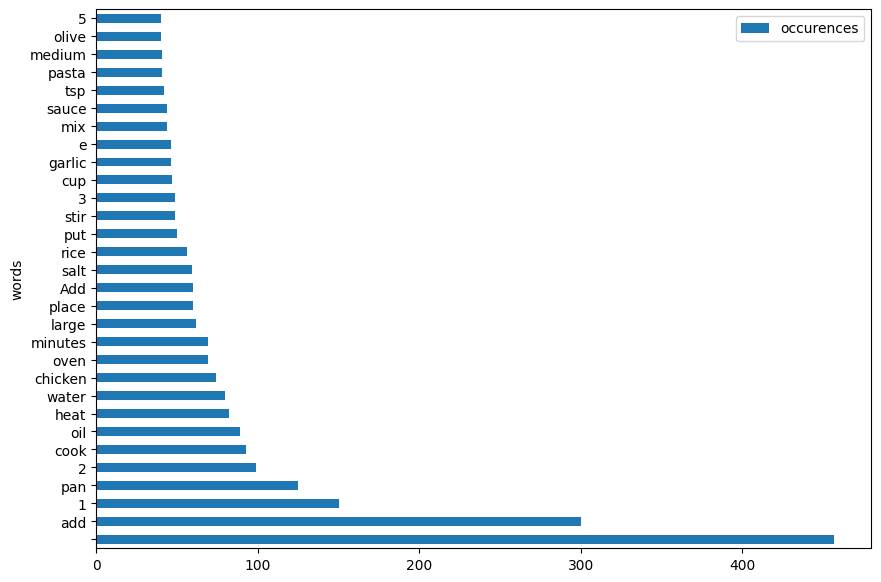

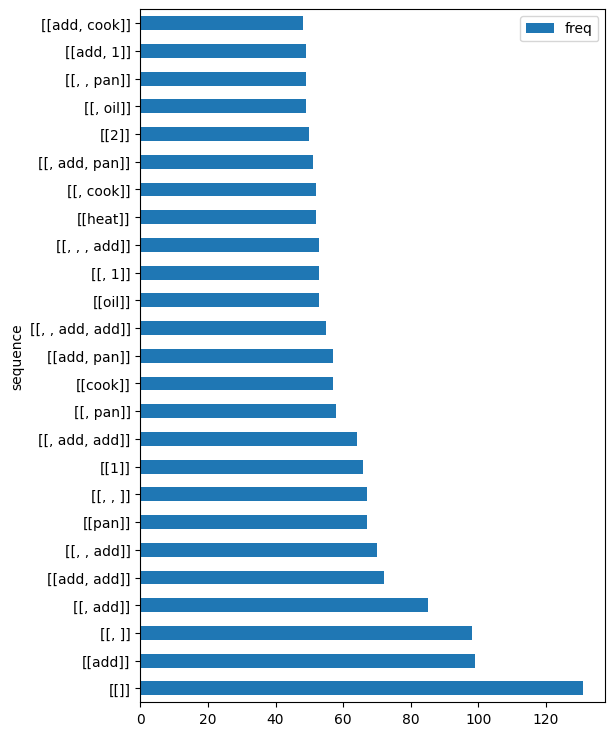

In [69]:
indices_of_first_attempts_per_user = df.groupby('user_id').head(1).index
data = pd.read_json('data/new_data.json').values

def filter_from_arrays(word):
    return word not in KEYWORDS and word not in stop_words and word not in noisy_punct

first_attempt_at_recipe_per_student = [list(map(lambda _: _['word'], filter(lambda _ : _ is not None, data[i]))) for i in indices_of_first_attempts_per_user]
#we filter the words we got from words in keywords, or stop words (like "the", "and"...) as well as punctuation
first_attempt_at_recipe_per_student = [list(filter(lambda _ : filter_from_arrays(_), first_attempt_at_recipe_per_student[i])) for i in range(len(indices_of_first_attempts_per_user))]

count_and_plot_most_common_words(flatten_and_filter_strings(first_attempt_at_recipe_per_student))
apply_prefixSpan(data=first_attempt_at_recipe_per_student, title="Prefix Span on the first content each user wrote")

What we do now is get the recipe each user submits in the end and recompute the PS algorithm

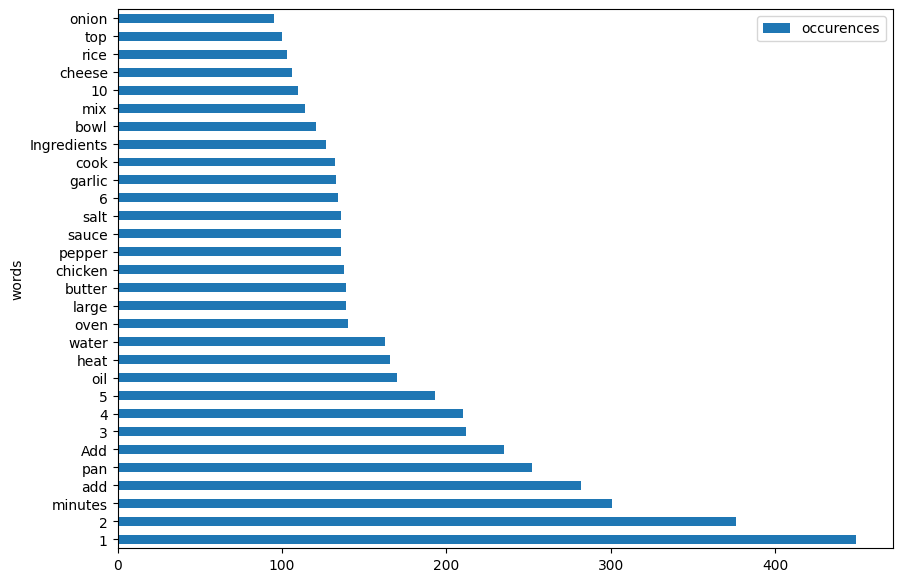

In [13]:
last_submitted_recipe_per_user = list(map(lambda index: index - 1, indices_of_first_attempts_per_user))[1:]
#we take the index of where the users first write and at the index i - 1 it is the index where the previous user last wrote!!
#and we do [1:] because where the first user first wrote is index 0, and 0 - 1 is out of bounds

recipes_submitted = [word_tokenize(df['recipe'].iloc[i]) for i in last_submitted_recipe_per_user]
recipes_submitted = [list(filter(lambda word: word not in stop_words and word not in noisy_punct, recipes_submitted[i])) for i in range(len(recipes_submitted))]
count_and_plot_most_common_words(flatten_and_filter_strings(recipes_submitted))
#apply_prefixSpan(data=recipes_submitted, minSupport=0.6,title="Prefix Span applied on the final recipe users submitted")

Can't really make anything of this which makes sense bc it looks for sequential patterns - not the general idea. For now this just confirms what the frequency word counter showed - that people make a list in their recipes but it's not that interesting.

We can see the suggestions have led to users enumerating things and be more descriptive

## Comparing text insertions with deletions

First what we want to do is count the number of deletions (ie Backspaces) for each student

we will create a tuple for each student of the form ```(total insertions, total deletions)```.
We create the same thing for each recipe in the dataset but it will be useful for later.

Also, what we do for each user: map their typing to insertions and deletions as 0s for insertions, 1s for deletions and try to see what different sequences of inserts/delete all users have. (so we don't do it for each sample, but for each user, otherwise the algorithm has to go through too many lists of data.)

Then we plot a scatter plot for each student and see if there are correlations between each student's writing.


In [63]:
all_keystrokes = pd.read_json('data/all_keystrokes.json').values
sorted_users = sorted(set(df['user_id'].values))
ins_del_dict = {'insert': 0, 'delete': 1}
student_sequences = []
recipe_sequences = []


recipe_insertions_deletions = []
user_insertions_deletions = []
for user in sorted_users:
    indices_where_written = np.where(df['user_id'] == user)
    insertions = 0
    deletions = 0
    student_sequence = []
    for index in indices_where_written:
        users_keystrokes = all_keystrokes[index]
        for recipe in users_keystrokes:
            recipe_sequence = []
            recipe_insertion = 0
            recipe_deletion = 0
            for dic in recipe:
                if dic is not None:
                    if dic['character'] not in KEYWORDS:
                        insertions += 1
                        recipe_insertion += 1
                        student_sequence.append(ins_del_dict['insert'])
                        recipe_sequence.append(ins_del_dict['insert'])
                    elif dic['character'] == 'Backspace':
                        deletions += 1
                        recipe_deletion += 1
                        student_sequence.append(ins_del_dict['delete'])
                        recipe_sequence.append(ins_del_dict['delete'])

            recipe_sequences.append(recipe_sequence)       
            recipe_insertions_deletions.append((recipe_insertion, recipe_deletion))
                        
    student_sequences.append(student_sequence)
    user_insertions_deletions.append((insertions, deletions))



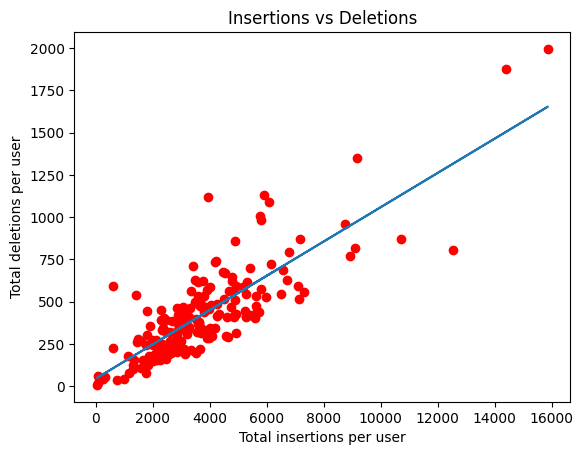

In [15]:
user_df = pd.DataFrame(user_insertions_deletions, columns=['insertions', 'deletions'])

X = user_df['insertions'].values.reshape(-1,1)
Y = user_df['deletions'].values.reshape(-1,1)

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X,Y)
y_pred = regressor.predict(X)
plt.scatter(X, Y, color='r')
plt.plot(X, y_pred)
plt.title('Insertions vs Deletions')
plt.xlabel('Total insertions per user')
plt.ylabel('Total deletions per user')
plt.show()



Clearly seems like there is a correlation between total user insertion and deletion

Let's try to plot the total insertions/deletions for a user and all the time they revise their recipe

We created a plot that takes any user index and returns the amount of revision they had with the % of deletions and insertions at each step
Later, we could add labels to each bar telling us the number of insertions and deletions for more information

In [58]:
def plot_percentages_for_user(user_index):
    assert user_index > 0 and user_index < 187
    user = recipe_insertions_deletions[indices_of_first_attempts_per_user[user_index]:indices_of_first_attempts_per_user[user_index+1]]
    percentage = []
    for i, (insert,deletes) in enumerate(user):
        s = insert + deletes
        percentage.append((round(insert/s*100, 2), round(deletes/s*100, 2)))

    dframe = pd.DataFrame(percentage, columns=['insertion %', 'deletion %'])
    dframe.plot(kind='bar', xlabel='revision step for user ' + str(user_index), ylabel='percentage')
    dframe.head()

def plot_stats_for_user(user_index):
    assert user_index > 0 and user_index < 187
    user = recipe_insertions_deletions[indices_of_first_attempts_per_user[user_index]:indices_of_first_attempts_per_user[user_index+1]]
    dframe = pd.DataFrame(user, columns=['insertions', 'deletions'])
    dframe.plot(kind='bar', xlabel='revision step for user ' + str(user_index))
    dframe.head()


We can plot three user's insertions and deletion % at random

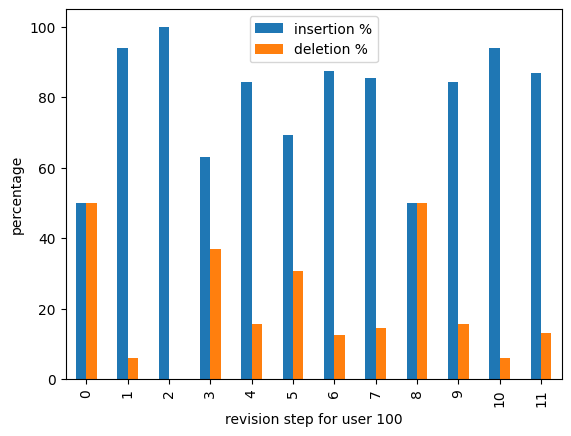

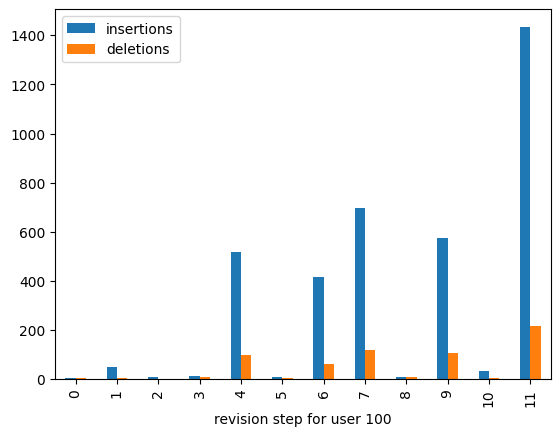

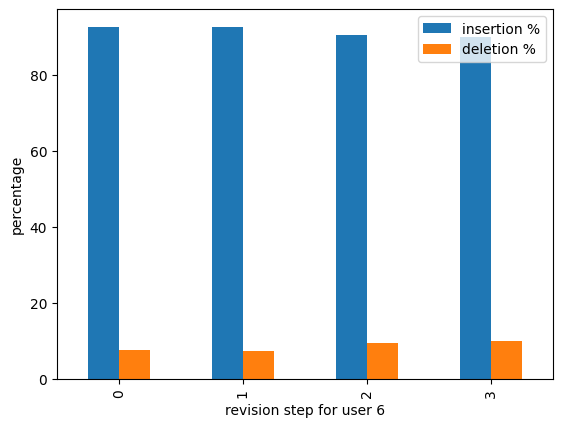

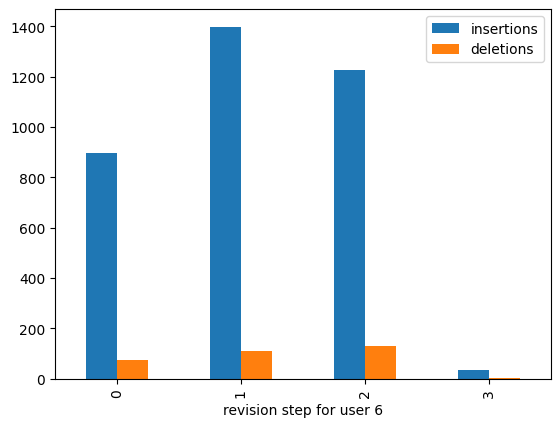

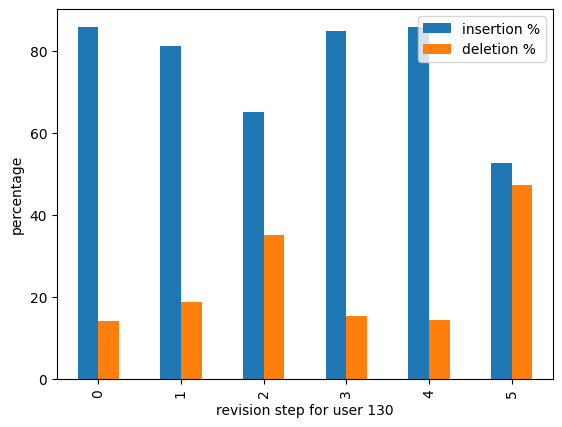

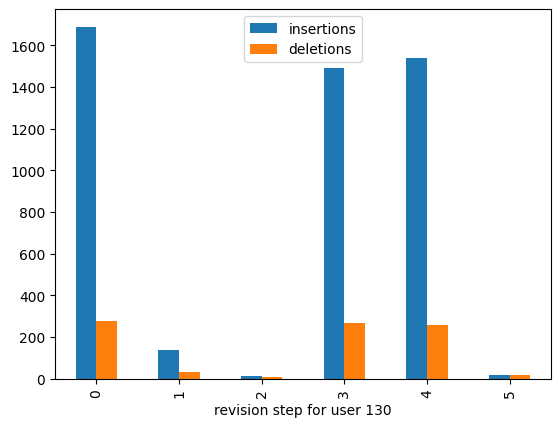

In [60]:
plot_percentages_for_user(100)
plot_stats_for_user(100)
plot_percentages_for_user(6)
plot_stats_for_user(6)
plot_percentages_for_user(130)
plot_stats_for_user(130)

#### Whats important to note is that the user at index 100, wrote 3 recipes!!! 1 from index 0 to 5, one from 6 to 8 and another one from 9 to 11 ask THIEMO how i can manage to see when someone is writing a new recipe. Look at the time from which they revise every time ? Or maybe look when the insertions spike from the previous revision!!!


We can see the amount of revision fluctuates a lot between users at each revision step but there is a general trend.

### Finding patterns in student insert/delete sequences


In [18]:
"""sequences = student_sequences
l = [Row(sequence=[s]) for s in sequences]
DF = sc.parallelize(l).toDF()
prefixSpan = PrefixSpan(minSupport=0.3, maxPatternLength=12, maxLocalProjDBSize=32000000)
# Find frequent sequential patterns.
a = prefixSpan.findFrequentSequentialPatterns(DF).sort(desc('freq')).collect()
NUM_PATTERNS_TO_PLOT = 30
df2 = pd.DataFrame(list(map(lambda _: _.asDict(),a[:NUM_PATTERNS_TO_PLOT])))
df2.plot(kind='barh',x='sequence', y='freq')

df2 = pd.DataFrame(list(map(lambda _: _.asDict(),a[NUM_PATTERNS_TO_PLOT: 2*NUM_PATTERNS_TO_PLOT])))
df2.plot(kind='barh',x='sequence', y='freq')
"""

#Takes 14 minutes to run with minSupport = .3 and maxPatternLength = 12


"sequences = student_sequences\nl = [Row(sequence=[s]) for s in sequences]\nDF = sc.parallelize(l).toDF()\nprefixSpan = PrefixSpan(minSupport=0.3, maxPatternLength=12, maxLocalProjDBSize=32000000)\n# Find frequent sequential patterns.\na = prefixSpan.findFrequentSequentialPatterns(DF).sort(desc('freq')).collect()\nNUM_PATTERNS_TO_PLOT = 30\ndf2 = pd.DataFrame(list(map(lambda _: _.asDict(),a[:NUM_PATTERNS_TO_PLOT])))\ndf2.plot(kind='barh',x='sequence', y='freq')\n\ndf2 = pd.DataFrame(list(map(lambda _: _.asDict(),a[NUM_PATTERNS_TO_PLOT: 2*NUM_PATTERNS_TO_PLOT])))\ndf2.plot(kind='barh',x='sequence', y='freq')\n"

We analyse the sequences of inserts and deletions from each users first time they write on the platform. To check what they write before they get any suggestions

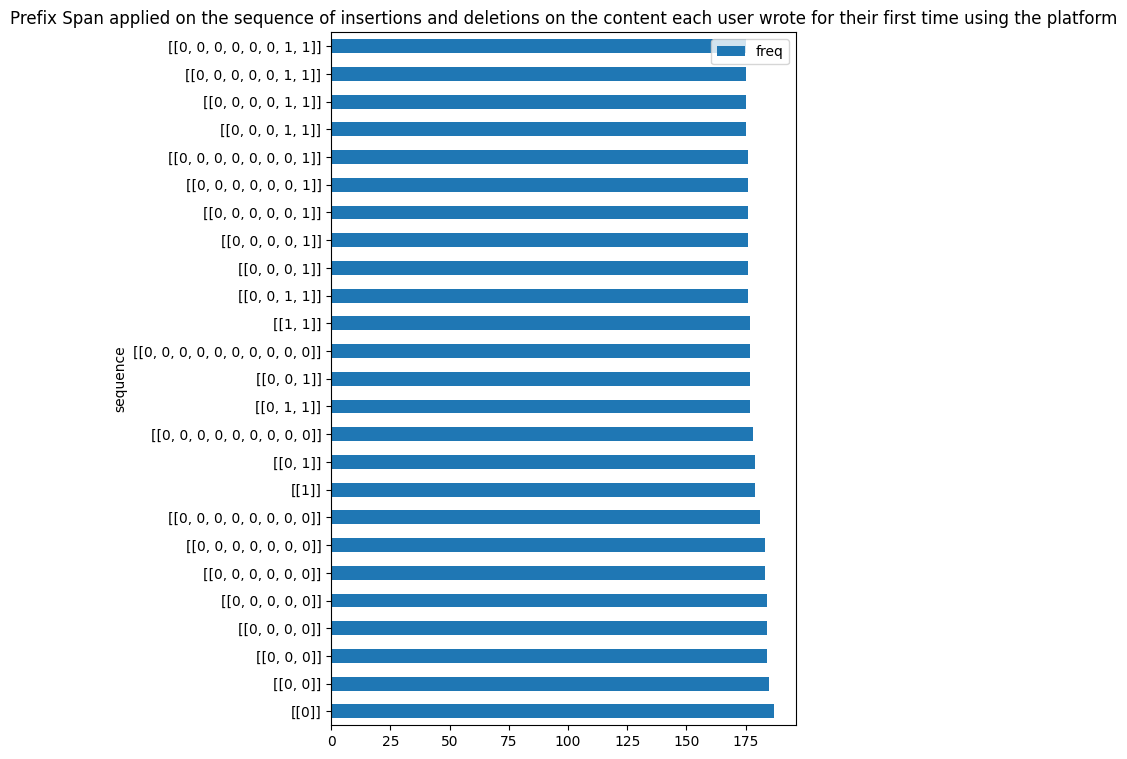

In [74]:
first_sequences_per_user = []
for index in indices_of_first_attempts_per_user:
    users_first_sequence = recipe_sequences[index]
    first_sequences_per_user.append(users_first_sequence)

apply_prefixSpan(first_sequences_per_user, minSupport=.2, maxPatternLength=10, title="Prefix Span applied on the sequence of insertions and deletions on the content each user wrote for their first time using the platform")

## Time Analysis TBC


Now we move on to the most important analysis for the project

##### !!!!! I just realised the system generates recipes based on user input so the cheating system we established is flawed because someone could simply write "enjoy!" and a 1000 characters long recipe could be generated (this example is one of our samples) so we need to review that!!!!!!!

So basically, what we want to do now is work with recipes where we know the input is genuine, so we can pick recipes with over 1000 insertions for example, where we know users genuinely write recipes instead of using flawed samples. 

In [19]:
#we keep only the recipes that have over 1000 insertions and group them with their indices
genuine_recipes = list(filter(lambda t: t[1][0] > 1000, enumerate(recipe_insertions_deletions)))
# so now we have a list of elements like (index, (inserts, deletions))
genuine_recipes = pd.DataFrame(genuine_recipes)
dataset = df
recipes = [dataset.iloc[i] for i in genuine_recipes[0]]


In [20]:
from datetime import datetime
import ast


for recipe in recipes[:2]:
    keystrokes = ast.literal_eval(recipe['ks'])
    start_time = keystrokes[0]['time']
    end_time = keystrokes[-1]['time']
    delta = end_time - start_time
    print(start_time)
    1662262452660
    1652426243.907874
    dt2 = datetime.fromtimestamp(1652426243.907874)
    dt1 = datetime.fromtimestamp(1652426243.907874)
    a = dt2 - dt1
    print(a.total_seconds)
    #print(delta_in_seconds)
    



# start and end timestamps
start_ts = 1652426243.907874
end_ts = 1652436243.907874

# convert timestamps to datetime object
dt1 = datetime.fromtimestamp(1662262125.132)
print('Datetime Start:', dt1)
dt2 = datetime.fromtimestamp(end_ts)
print('Datetime End:', dt2)

# Difference between two timestamps
# in hours:minutes:seconds format
delta = dt2 - dt1
print('Difference is:', delta)

1662301737313
<built-in method total_seconds of datetime.timedelta object at 0x00000139C8D5B630>
1662300860474
<built-in method total_seconds of datetime.timedelta object at 0x00000139DD3118A0>
Datetime Start: 2022-09-04 05:28:45.132000
Datetime End: 2022-05-13 12:04:03.907874
Difference is: -114 days, 6:35:18.775874
